In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

D:\setup\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# Загрузка датасета
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
print("Размер датасета:", df.shape)
print("\nРаспределение оценок:")
print(df['Rating'].value_counts().sort_index())

Размер датасета: (20491, 2)

Распределение оценок:
Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64


In [4]:
class HotelReviewsDataset(Dataset):
    def __init__(self, reviews, ratings, tokenizer, max_length=128):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        rating = self.ratings[idx]
        
        encoded = self.tokenizer.encode_plus(
            review,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
            return_attention_mask=True
        )
        
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'labels': torch.tensor(rating - 1, dtype=torch.long)
        }

In [5]:
# Разделение данных
X = df['Review'].values
y = df['Rating'].values

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, 
                                                 stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, 
                                                 stratify=y_temp, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Создание датасетов
train_dataset = HotelReviewsDataset(X_train, y_train, tokenizer)
val_dataset = HotelReviewsDataset(X_val, y_val, tokenizer)
test_dataset = HotelReviewsDataset(X_test, y_test, tokenizer)

# Создание даталоадеров с уменьшенным batch_size
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [6]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes=5):
        super(CNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.conv1 = nn.Conv1d(embed_dim, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(256)
        self.conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, num_classes)
        
    def forward(self, x, attention_mask=None):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [7]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1,
                           batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x, attention_mask=None):
        embedded = self.embedding(x)
        
        if attention_mask is not None:
            embedded = embedded * attention_mask.unsqueeze(-1)
        
        lstm_out, _ = self.lstm(embedded)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        x = self.dropout(context_vector)
        x = self.fc(x)
        return x

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    early_stopping = EarlyStopping(patience=5)
    
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        # Валидация
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        # Обновление scheduler
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)
        
        # Early Stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [9]:
vocab_size = tokenizer.vocab_size
embed_dim = 128
hidden_dim = 256
num_classes = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [11]:
cnn_model = CNNClassifier(vocab_size, embed_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

cnn_results = train_model(cnn_model, train_loader, val_loader, 
                         criterion, optimizer, scheduler, num_epochs=30, device=device)

Epoch 1/30:
Train Loss: 1.8199, Train Accuracy: 36.03%
Val Loss: 1.3886, Val Accuracy: 44.17%
------------------------------------------------------------
Epoch 2/30:
Train Loss: 1.5439, Train Accuracy: 37.48%
Val Loss: 1.3909, Val Accuracy: 44.19%
------------------------------------------------------------
Epoch 3/30:
Train Loss: 1.4619, Train Accuracy: 39.53%
Val Loss: 1.3568, Val Accuracy: 44.19%
------------------------------------------------------------
Epoch 4/30:
Train Loss: 1.3959, Train Accuracy: 41.65%
Val Loss: 1.3080, Val Accuracy: 44.19%
------------------------------------------------------------
Epoch 5/30:
Train Loss: 1.3526, Train Accuracy: 42.61%
Val Loss: 1.2878, Val Accuracy: 44.19%
------------------------------------------------------------
Epoch 6/30:
Train Loss: 1.3154, Train Accuracy: 43.66%
Val Loss: 1.2536, Val Accuracy: 44.19%
------------------------------------------------------------
Epoch 7/30:
Train Loss: 1.2705, Train Accuracy: 44.33%
Val Loss: 1.199

In [12]:
lstm_model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

lstm_results = train_model(lstm_model, train_loader, val_loader, 
                          criterion, optimizer, scheduler, num_epochs=30, device=device)

Epoch 1/30:
Train Loss: 1.2967, Train Accuracy: 45.03%
Val Loss: 1.1756, Val Accuracy: 48.61%
------------------------------------------------------------
Epoch 2/30:
Train Loss: 1.1196, Train Accuracy: 51.00%
Val Loss: 1.0560, Val Accuracy: 52.95%
------------------------------------------------------------
Epoch 3/30:
Train Loss: 1.0254, Train Accuracy: 55.29%
Val Loss: 1.0206, Val Accuracy: 54.90%
------------------------------------------------------------
Epoch 4/30:
Train Loss: 0.9761, Train Accuracy: 56.97%
Val Loss: 0.9928, Val Accuracy: 57.13%
------------------------------------------------------------
Epoch 5/30:
Train Loss: 0.9381, Train Accuracy: 59.00%
Val Loss: 0.9823, Val Accuracy: 57.44%
------------------------------------------------------------
Epoch 6/30:
Train Loss: 0.9045, Train Accuracy: 60.22%
Val Loss: 0.9625, Val Accuracy: 58.22%
------------------------------------------------------------
Epoch 7/30:
Train Loss: 0.8797, Train Accuracy: 61.43%
Val Loss: 0.977

In [13]:
def plot_metrics(cnn_results, lstm_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # График потерь
    ax1.plot(cnn_results[0], label='CNN Train')
    ax1.plot(cnn_results[1], label='CNN Val')
    ax1.plot(lstm_results[0], label='LSTM Train')
    ax1.plot(lstm_results[1], label='LSTM Val')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # График точности
    ax2.plot(cnn_results[2], label='CNN Train')
    ax2.plot(cnn_results[3], label='CNN Val')
    ax2.plot(lstm_results[2], label='LSTM Train')
    ax2.plot(lstm_results[3], label='LSTM Val')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

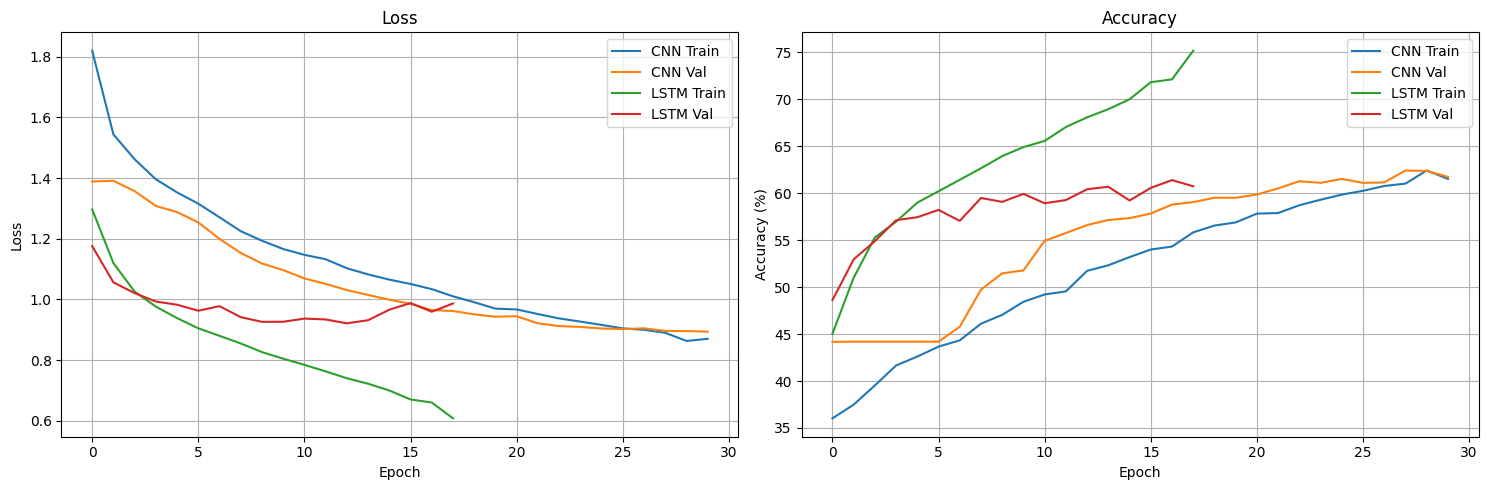

In [14]:
plot_metrics(cnn_results, lstm_results)

# Анализ результатов обучения моделей

## Анализ графиков обучения

### Loss
- CNN модель демонстрирует стабильное снижение функции потерь как на тренировочной, так и на валидационной выборке
- LSTM модель показывает более быстрое снижение функции потерь на тренировочных данных, но менее стабильное поведение на валидации
- Обе модели достигают схожих значений loss на валидации (~0.9)

### Accuracy
- LSTM достигает более высокой точности на тренировочных данных (75%) по сравнению с CNN (62%)
- На валидационной выборке обе модели показывают схожую точность около 60%
- LSTM быстрее достигает высоких значений accuracy в начале обучения

## Возможные улучшения

1. Применить более сильную регуляризацию для LSTM модели для уменьшения разрыва между тренировочной и валидационной точностью
2. Увеличить сложность CNN модели для потенциального улучшения точности
3. Использовать ансамблирование обеих моделей для получения более стабильных предсказаний